# Experiment - Approximate Mutual Information

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])
pysim_root = "/home/emmanuel/code/pysim"
# append to path
sys.path.append(str(root))
sys.path.append(str(pysim_root))

import numpy as np

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
import corner

sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2
%load_ext lab_black

## Mutual Information

In [2]:
# ==========================
# INITIALIZE LOGGER
# ==========================
import wandb

wandb_logger = wandb.init(project="sim4clim_mi", entity="ipl_uv")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ml4floods (use `wandb login --relogin` to force relogin)


### Dataset

In [3]:
from pysim.data.information.gaussian import generate_gaussian_mi_data
from pysim.data.information.studentt import generate_studentt_mi_data


from typing import NamedTuple


class MIResult(NamedTuple):
    time: float
    MI: float
    name: str


def get_mi_datasets(n_samples, n_features, seed, dataset="gaussian", **kwargs):

    if dataset == "gaussian":

        res = generate_gaussian_mi_data(
            n_samples=n_samples,
            n_features=n_features,
            seed=seed,
            n_base_samples=500_000,
        )

    elif dataset == "studentt":

        res = generate_studentt_mi_data(
            n_samples=n_samples,
            n_features=n_features,
            seed=seed,
            n_base_samples=500_000,
            df=kwargs.get("df", 3.0),
        )

    elif dataset == "cauchy":

        res = generate_studentt_mi_data(
            n_samples=n_samples,
            n_features=n_features,
            seed=seed,
            n_base_samples=500_000,
            df=1.0,
        )

    else:
        raise ValueError(f"Unrecognized estimator.")

    return res

### Estimators

In [4]:
# !pip install "git+https://github.com/gregversteeg/NPEET.git"
# !pip install mutual-info
rbig_root = "/home/emmanuel/code/rbig"
sys.path.append(str(rbig_root))

In [5]:
from mutual_info.mutual_info import mutual_information as mi_mutual_info
from npeet.entropy_estimators import mi as npeet_mutual_info

In [6]:
from pysim.information.gaussian import gauss_entropy_multi
from pysim.information.knn import knn_entropy, knn_entropy_npeet
from pysim.information.mutual import multivariate_mutual_information
import time


def get_mi_estimators(X, Y, method="gaussian", **kwargs):

    if method == "gaussian":
        t0 = time.time()
        res = multivariate_mutual_information(
            X=X.copy(), Y=Y.copy(), f=gauss_entropy_multi
        )
        t1 = time.time() - t0
        return MIResult(t1, res.MI, "gaussian")

    elif method == "knn_nbs":
        t0 = time.time()
        res = mi_mutual_info((X.copy(), Y.copy()), k=kwargs.get("k", 5), transform=None)
        t1 = time.time() - t0
        return MIResult(t1, res, "knn_nbs")

    elif method == "knn_eps":
        t0 = time.time()
        res = npeet_mutual_info(
            x=X.copy(), y=Y.copy(), base=np.e, k=kwargs.get("k", 5),
        )
        t1 = time.time() - t0
        return MIResult(t1, res, "knn_eps")

    elif method == "rv":
        from hyppo.independence import RV

        t0 = time.time()
        res = res = RV().statistic(x=X.copy(), y=Y.copy())
        t1 = time.time() - t0
        return MIResult(t1, res, "rv")

    elif method == "nhsic_lin":
        from hyppo.independence import Hsic

        t0 = time.time()
        hsic_model = Hsic(compute_kernel="linear")
        res = hsic_model.statistic(x=X.copy(), y=Y.copy())
        t1 = time.time() - t0
        return MIResult(t1, res, "nhsic_lin")

    elif method == "nhsic_rbf":
        from hyppo.independence import Hsic

        t0 = time.time()
        hsic_model = Hsic(compute_kernel="rbf")
        res = hsic_model.statistic(x=X.copy(), y=Y.copy())
        t1 = time.time() - t0
        return MIResult(t1, res, "nhsic_rbf")

    elif method == "mmd":
        from hyppo.ksample import MMD

        t0 = time.time()
        res = MMD(compute_kernel="gaussian").statistic(x=X.copy(), y=Y.copy())
        t1 = time.time() - t0
        return MIResult(t1, res, "mmd")

    elif method == "rbig":
        from rbig.rbig import RBIGMI

        t0 = time.time()
        rbig_model = RBIGMI(pdf_extension=10)
        rbig_model.fit(X.copy(), Y.copy())
        t1 = time.time() - t0
        mi = rbig_model.mutual_information() * np.log(2)
        return MIResult(t1, mi, "rbig")
    else:
        raise ValueError(f"Unrecognized estimator.")

## Toy Data

In [10]:
from pysim.utils import dict_product

params = {
    "n_samples": [1_000, 2_000, 5_000, 10_000],
    "n_features": [1, 2, 5, 10],
    "n_trials": list(np.arange(1, 21)),
    "dataset": ["gaussian"],  # ["gaussian", "studentt", "cauchy"],
}
params = dict_product(params)

models = [
    "rbig"
]  # ["gaussian", "rv", "knn_nbs", "knn_eps", "nhsic_lin", "nhsic_rbf", "mmd"]

### Gaussian

**Implementation Notes**:

1. We randomly generate a positive semi-definite $D \times D$ matrix. This acts as our covariance matrix $\boldsymbol{\Sigma}$.

2. We use a mean, $\boldsymbol{\mu}$ of $\mathbf{0}$.

3. We generate an upper limit of 5e5 data points and then random subset the requested number.

In [11]:
from functools import partial
from tqdm.autonotebook import tqdm, trange

In [12]:
import tqdm
import pandas as pd

results_df = pd.DataFrame()
results_dict = {}

with tqdm.tqdm(params) as pbar:

    for i, iparam in enumerate(pbar):

        pbar.set_description(
            f"Samples: {iparam['n_samples']} | Features: {iparam['n_features']} | Trial: {iparam['n_trials']}"
        )

        # generate data
        res_tuple = get_mi_datasets(
            n_samples=iparam["n_samples"],
            n_features=iparam["n_features"],
            seed=iparam["n_trials"],
            dataset=iparam["dataset"],
        )

        results_dict = {**results_dict, **iparam}
        results_dict["model"] = "true"
        results_dict["dataset"] = iparam["dataset"]
        results_dict["mi"] = res_tuple.MI

        results_dict["time"] = 0.0

        results_df = pd.concat(
            [results_df, pd.DataFrame(results_dict, index=[i])], axis=0
        )

        # GAUSSIAN APPROXIMATION

        #         with tqdm.tqdm(models, leave=False) as pbar_models:
        for imodel in models:

            #                 pbar_models.set_description(
            #                     f"Model: {imodel}"
            #                 )

            # KNN (NEIGHBOURS)

            # do calculation
            res = get_mi_estimators(
                X=res_tuple.X.copy(), Y=res_tuple.Y.copy(), method=imodel
            )

            results_dict = {**results_dict, **iparam}
            results_dict["model"] = res.name
            results_dict["dataset"] = iparam["dataset"]
            results_dict["approx"] = res.MI
            results_dict["true"] = res_tuple.MI
            results_dict["time"] = res.time

            results_df = pd.concat(
                [results_df, pd.DataFrame(results_dict, index=[i])], axis=0
            )

Samples: 10000 | Features: 10 | Trial: 20: 100%|██████████| 320/320 [37:03<00:00,  6.95s/it]


In [10]:
results_df.tail()

,n_samples,n_features,n_trials,dataset,model,mi,time,approx,true
45,10000,10,1,gaussian,rbig,2.615439,19.121723,2.598405,2.615439
46,10000,10,1,studentt,true,3.134896,0.000000,2.598405,2.615439
46,10000,10,1,studentt,rbig,3.134896,19.140095,2.392440,3.134896
47,10000,10,1,cauchy,true,3.735070,0.000000,2.392440,3.134896
47,10000,10,1,cauchy,rbig,3.735070,63.405044,22.628207,3.735070


In [26]:
wandb.log({"sim_results": wandb.Table(dataframe=results_df)})

In [36]:
import json

with open("./temp_res.json") as json_data:
    data = json.load(json_data)

results_df = pd.DataFrame(data["data"], columns=data["columns"])
results_df.head()

,n_samples,n_features,n_trials,dataset,model,mi,time,approx,true
0,1000,1,1,gaussian,true,0.452329,0.000000,0.000000,0.000000
1,1000,1,1,gaussian,gaussian,0.452329,0.002186,0.451450,0.452329
2,1000,1,1,gaussian,rv,0.452329,0.000250,0.593796,0.452329
3,1000,1,1,gaussian,knn_nbs,0.452329,0.024578,0.414026,0.452329
4,1000,1,1,gaussian,knn_eps,0.452329,0.011041,0.428369,0.452329


In [26]:
results_df_approx = results_df.copy()

In [24]:
def create_results_xr(df):
    
    # get the ground

    # drop columns
    df = df.drop(["n_samples", "n_features"], axis=0)

    # make index the experiment params
    df = df.set_index(["model", "n_samples", "n_features", "n_trials", "dataset"])

    #
    df_xr = df.to_xarray()

    return df_xr

## Results

### Demo Plot

In [11]:
def get_mu_std(df, model, dataset="gaussian"):

    df = df[df["model"] == model]
    df = df[df["dataset"] == dataset]

    # get true values
    df_true = df["mi"]
    df_approx = df["approx"]

    return df_approx, df_true

In [12]:
df_knn, df_true = get_mu_std(results_df, "rbig")

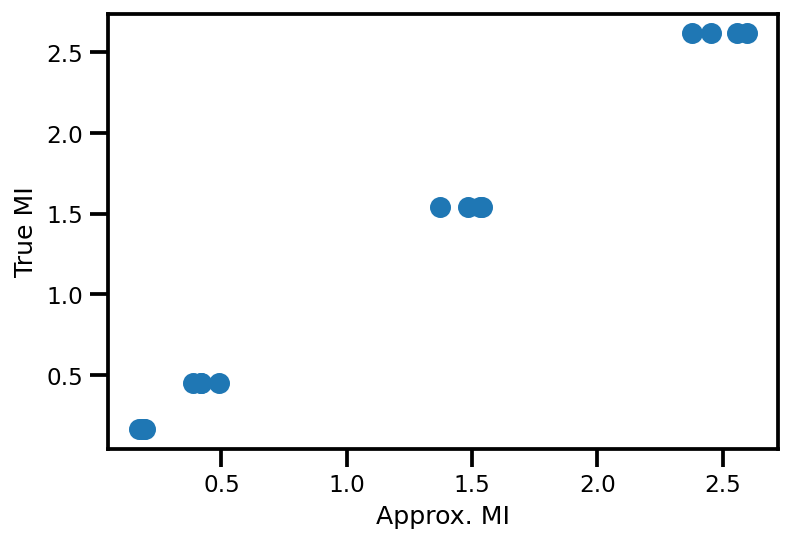

In [13]:
fig, ax = plt.subplots()

ax.scatter(df_knn.values, df_true.values)
ax.set(xlabel="Approx. MI", ylabel="True MI")
plt.show()

## Results

In [49]:
def plot_results(results_df, model="gaussian", dataset="gaussian"):

    df_approx, df_true = get_mu_std(results_df, model, dataset)

    fig, ax = plt.subplots()

    ax.scatter(df_approx.values, df_true.values)
    ax.set(xlabel="Approx. Mutual Info", ylabel="True Mutual Info")
    ax.set_title(f"Data: {dataset} | Model: {model}")
    plt.tight_layout()
    plt.show()
    wandb.log({f"scatter_{dataset}_{model}": wandb.Image(fig)})

### Gaussian Distribution

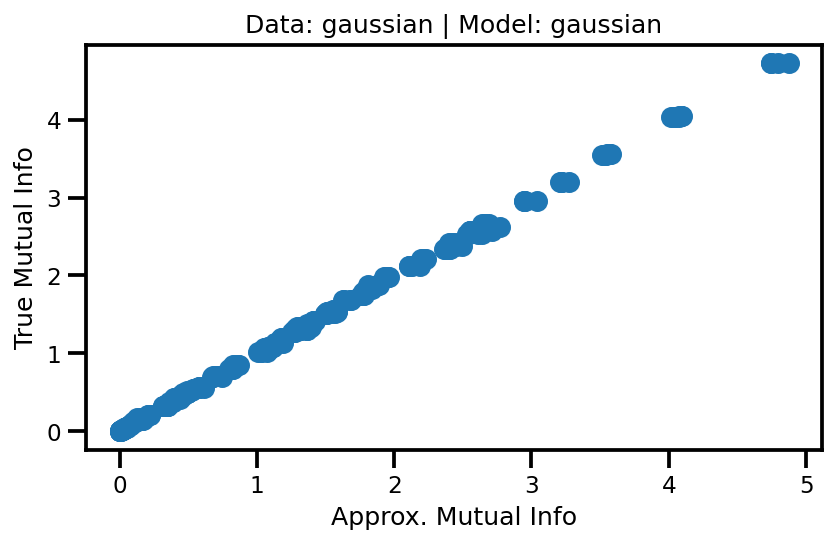

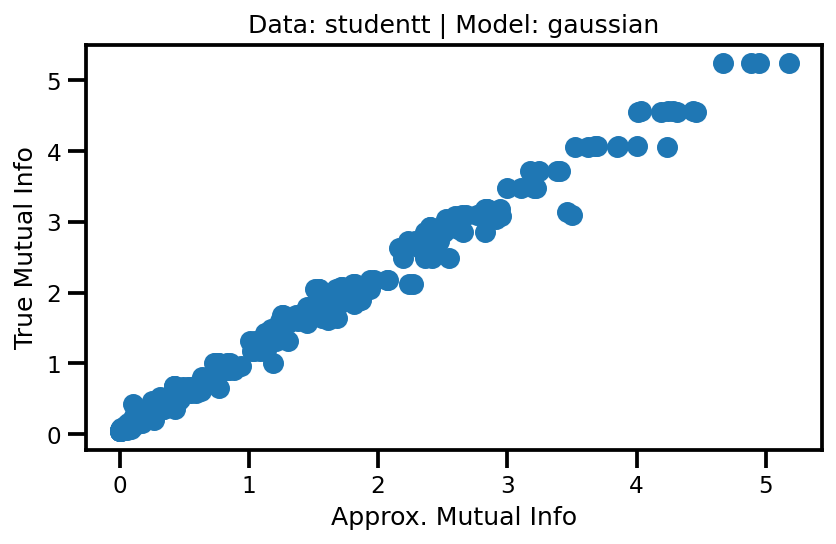

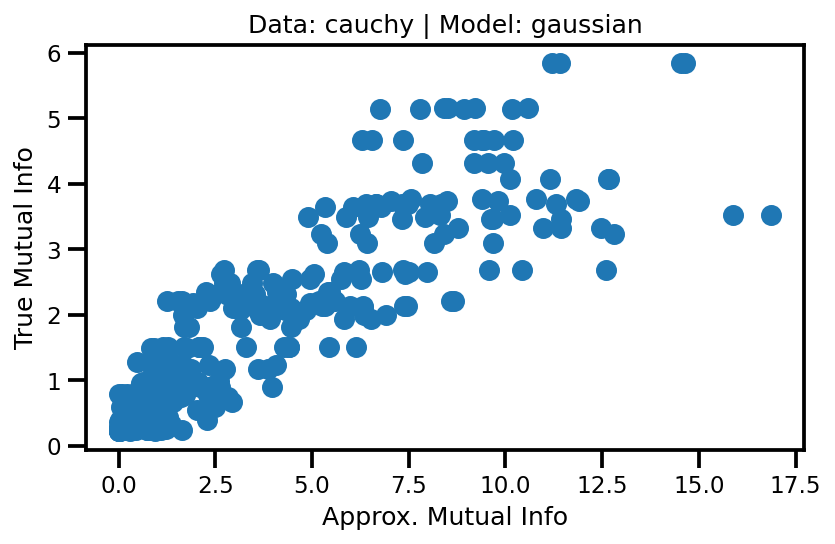

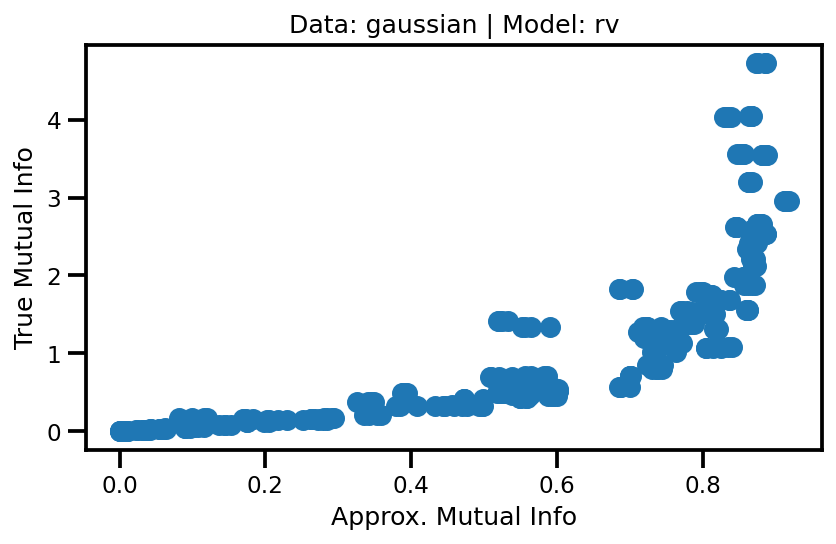

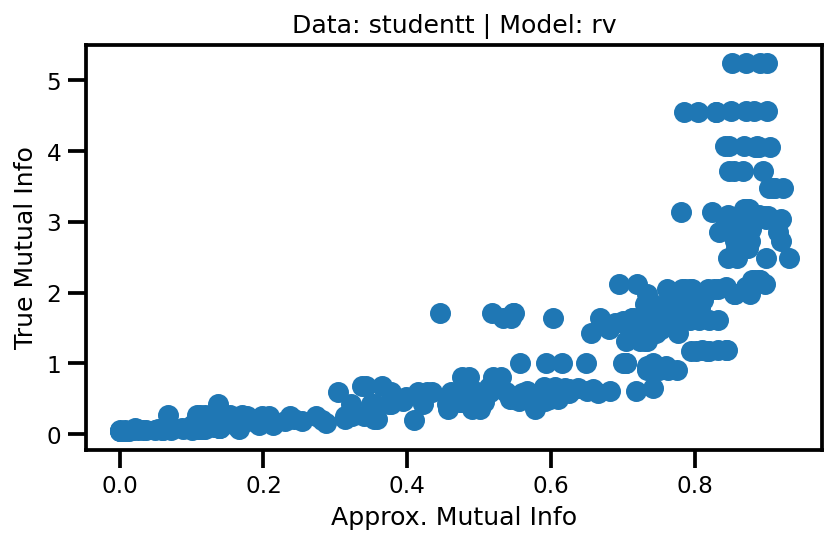

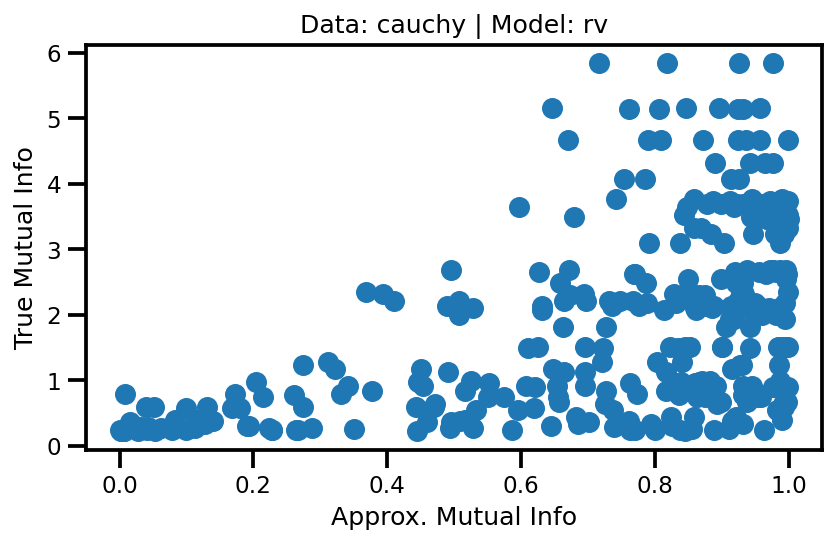

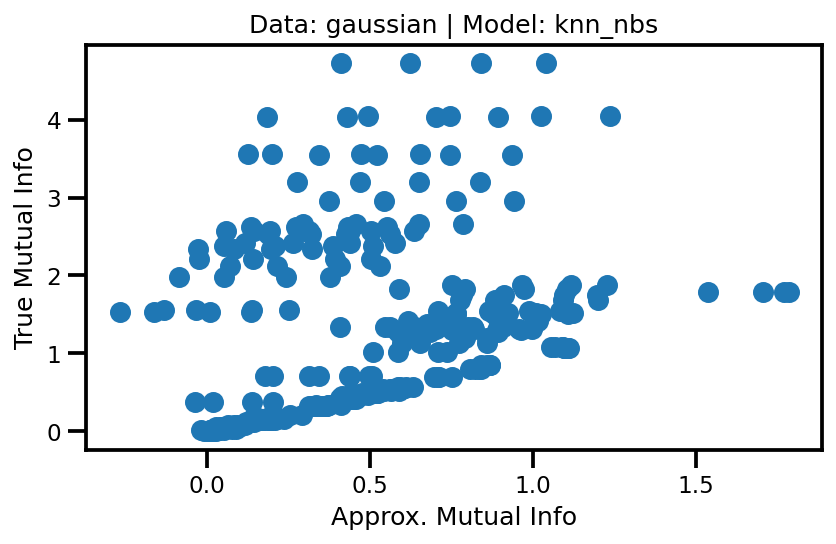

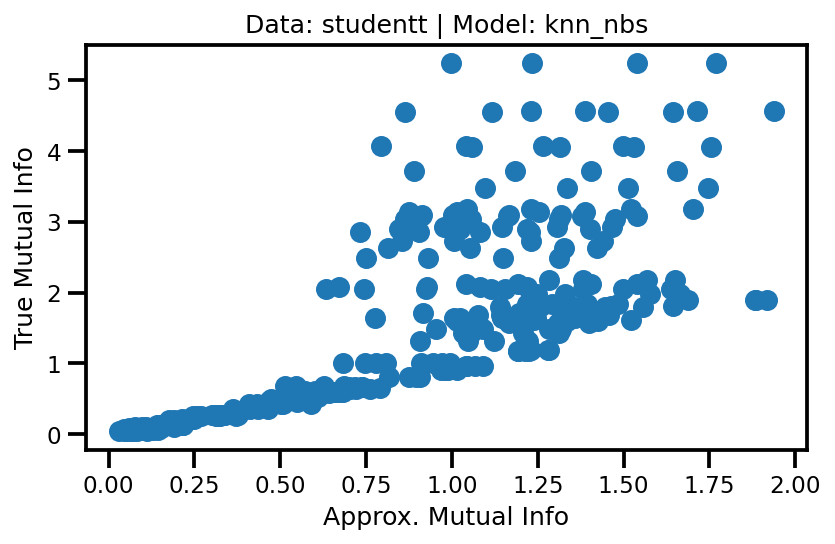

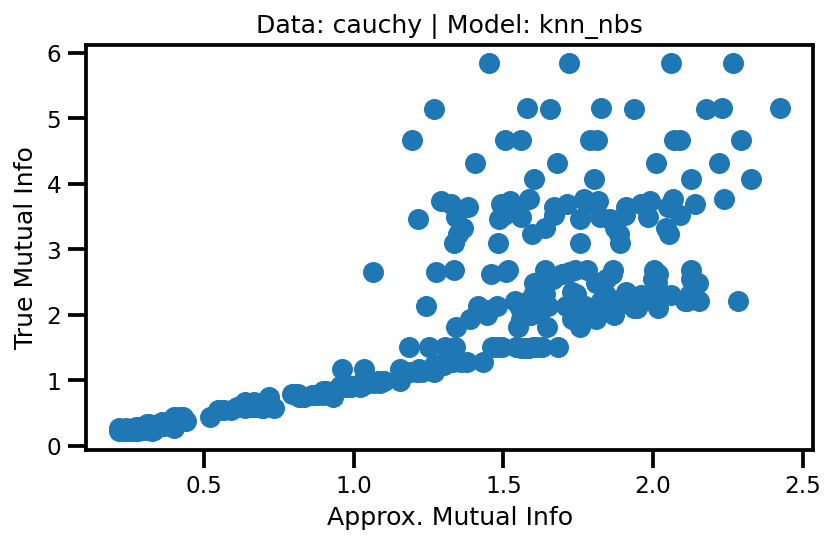

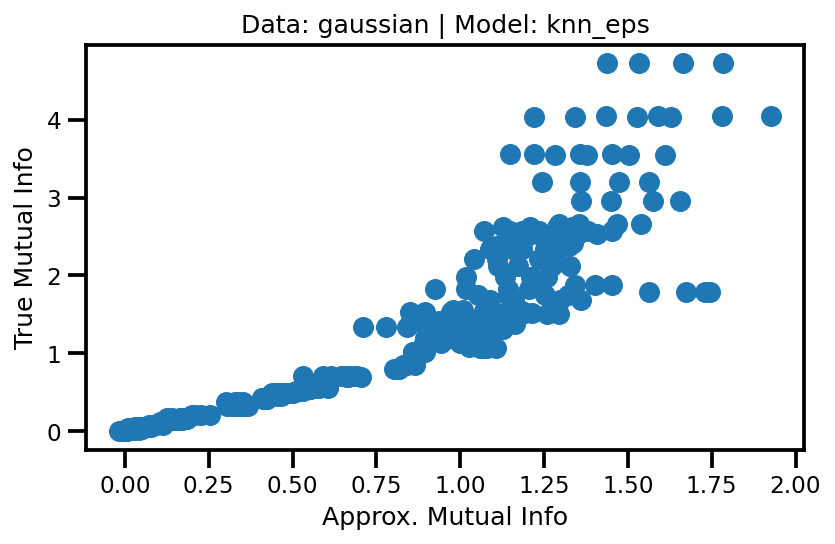

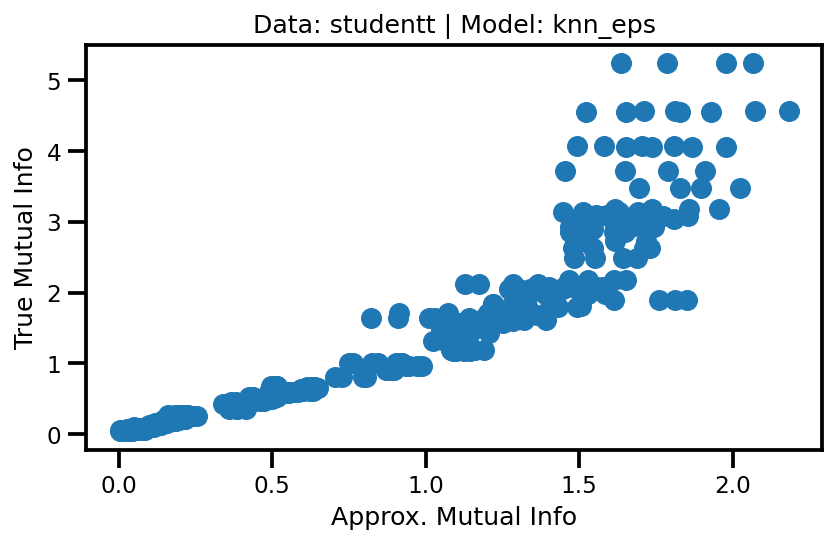

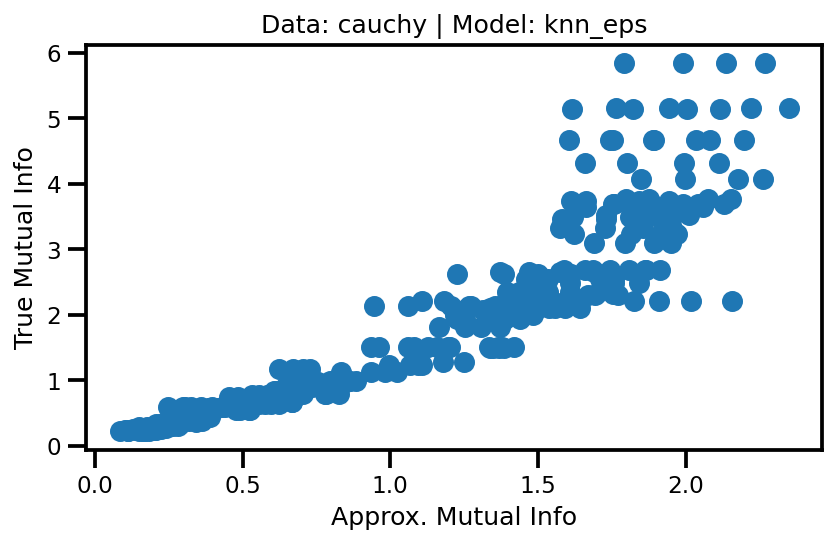

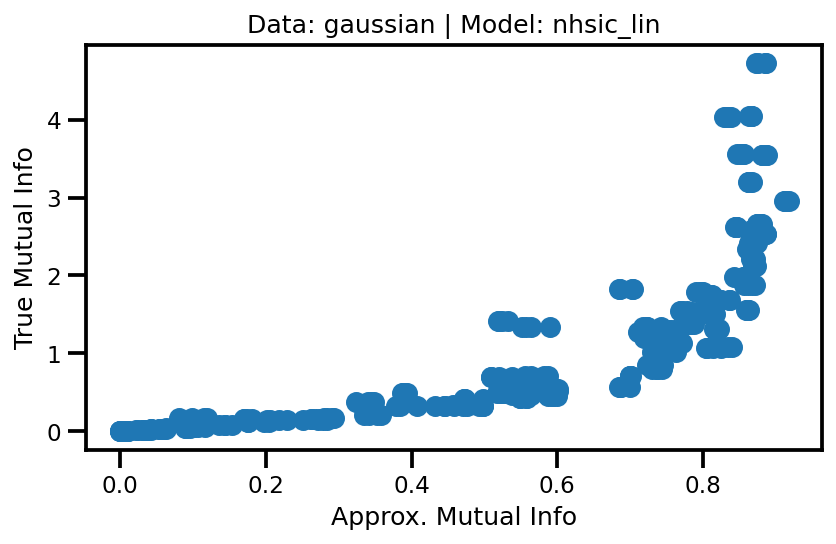

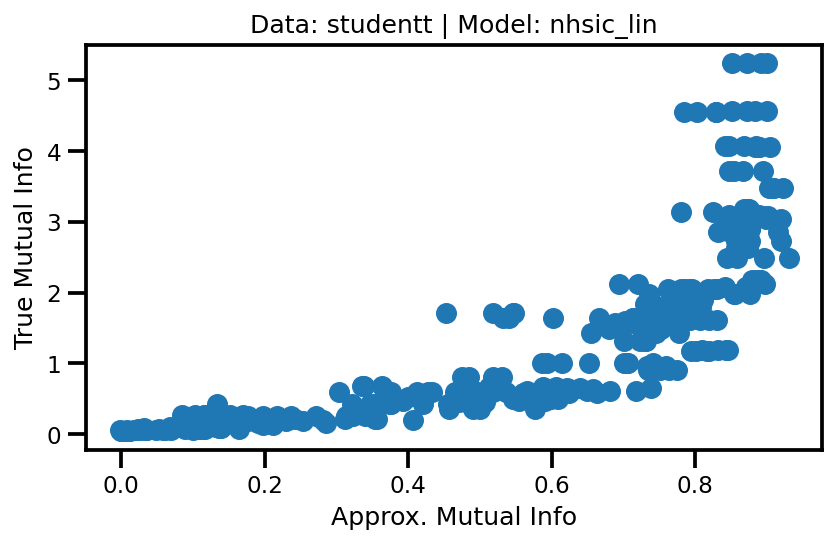

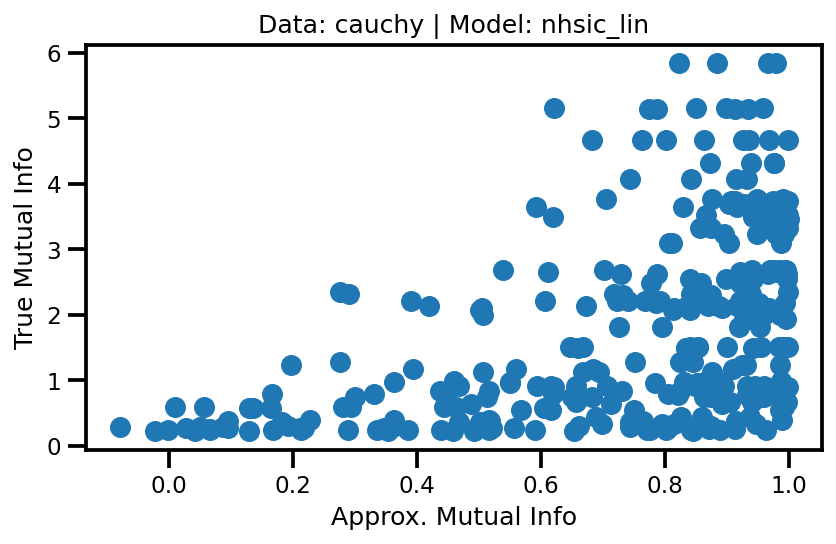

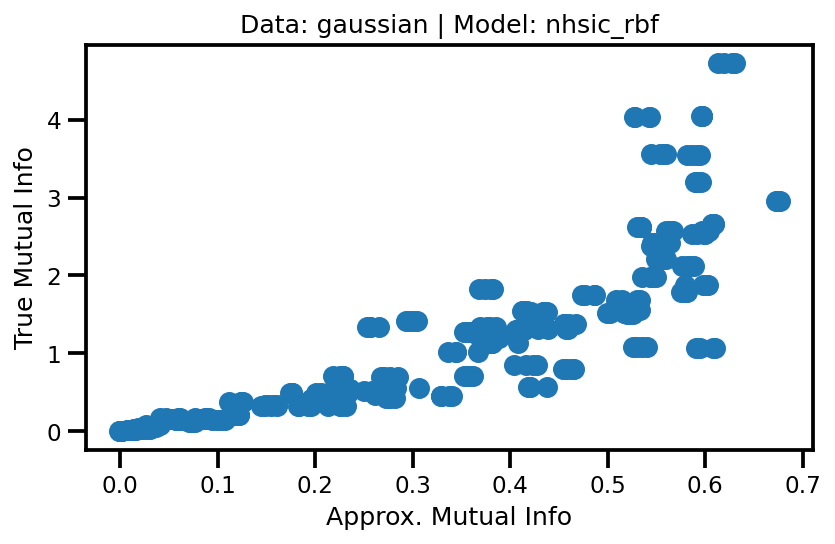

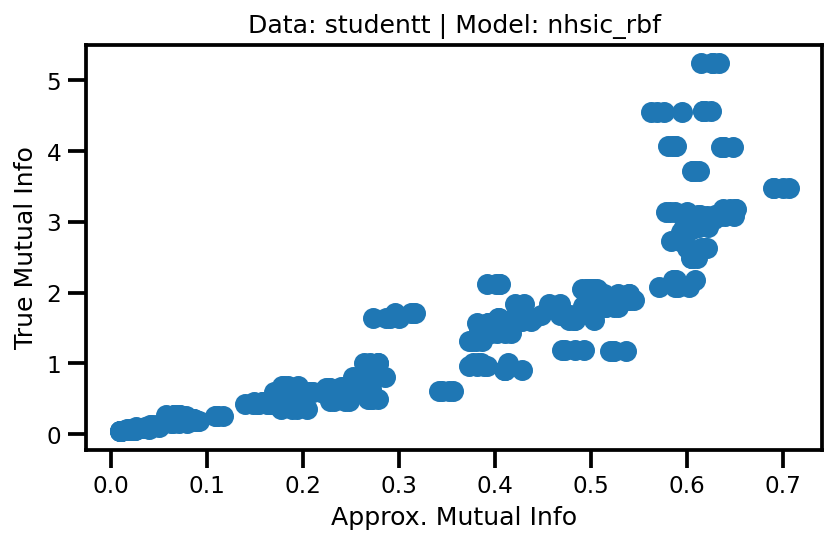

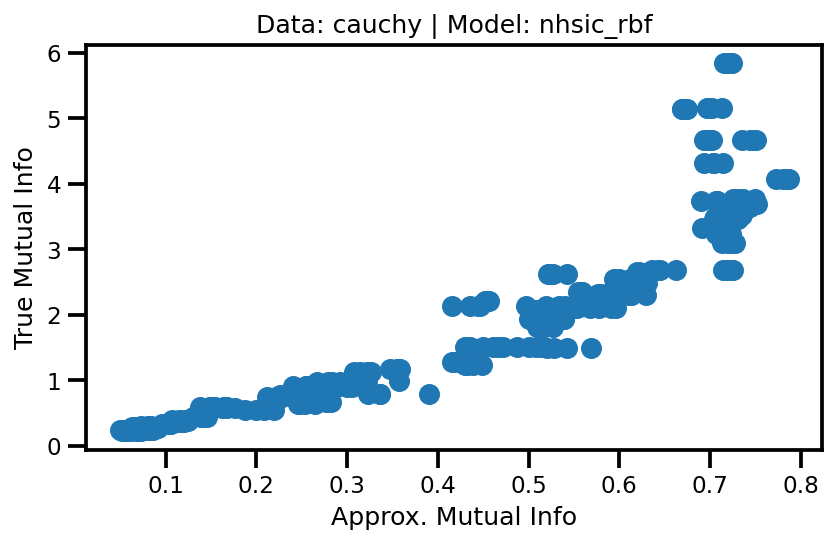

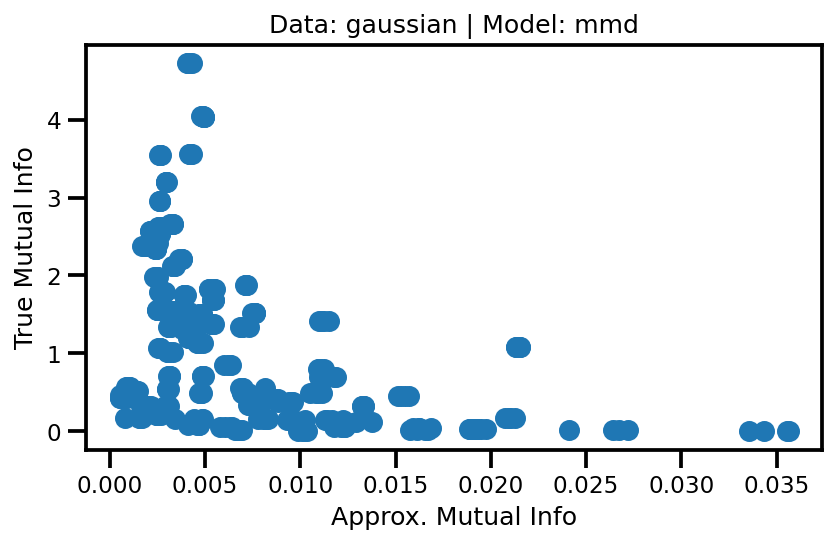

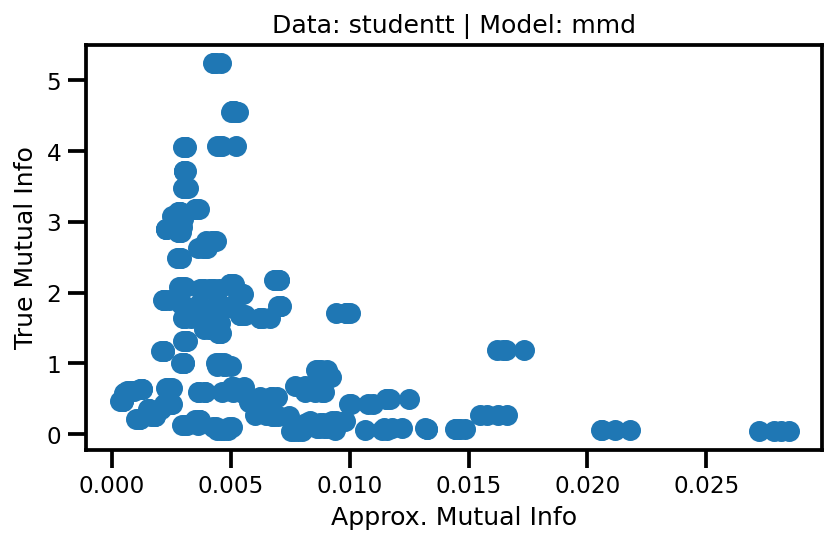

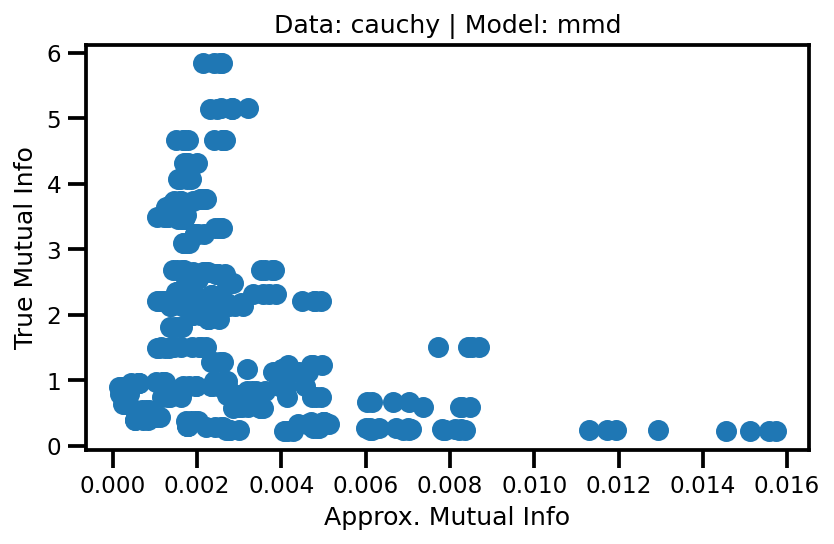

In [51]:
models = ["gaussian", "rv", "knn_nbs", "knn_eps", "nhsic_lin", "nhsic_rbf", "mmd"]
datasets = ["gaussian", "studentt", "cauchy"]

for imodel in models:
    for idataset in datasets:

        plot_results(results_df, model=imodel, dataset=idataset)

#### k-NN Approximation

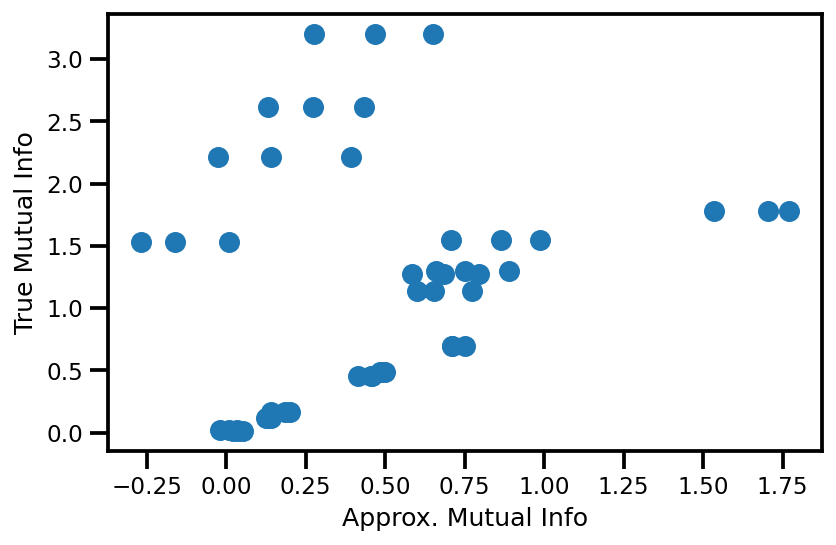

In [78]:
plot_results(results_df, "knn_nbs")

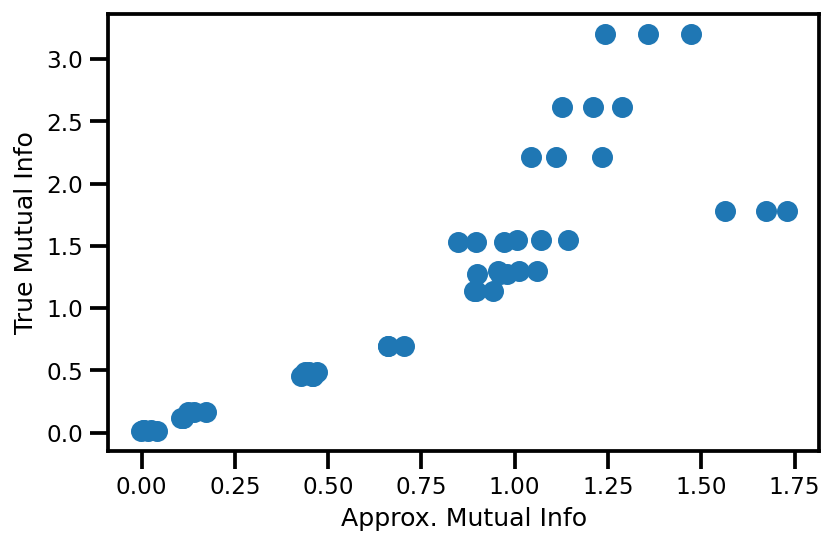

In [79]:
plot_results(results_df, "knn_eps")

#### RV Coefficient

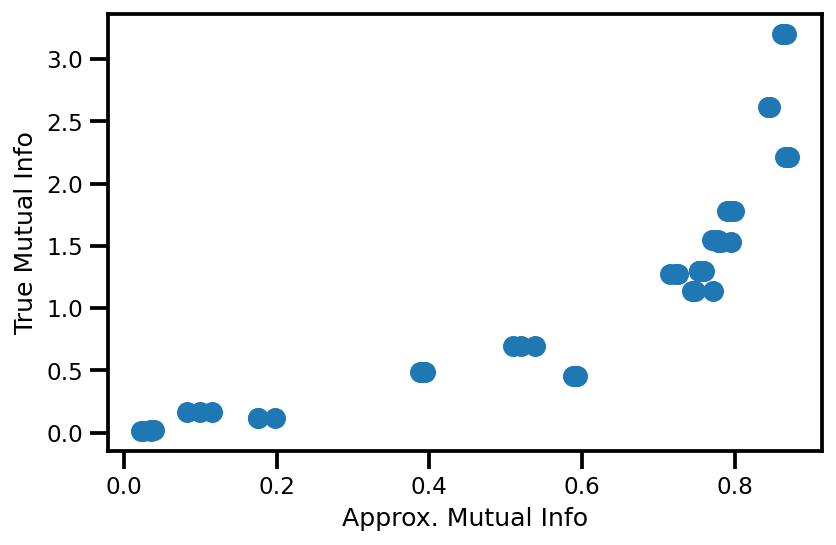

In [80]:
plot_results(results_df, "rv")

#### nHSIC (Linear)

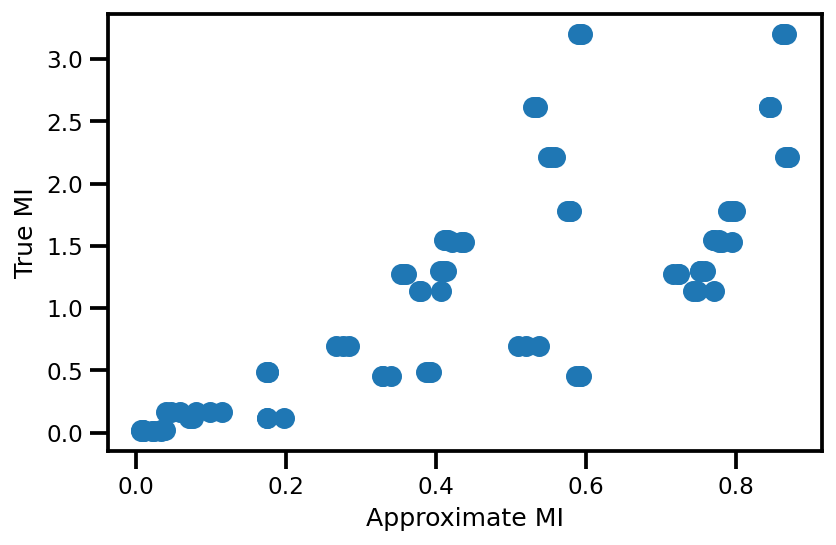

In [68]:
plot_results(results_df, "nhsic_lin")

#### nHSIC (RBF)

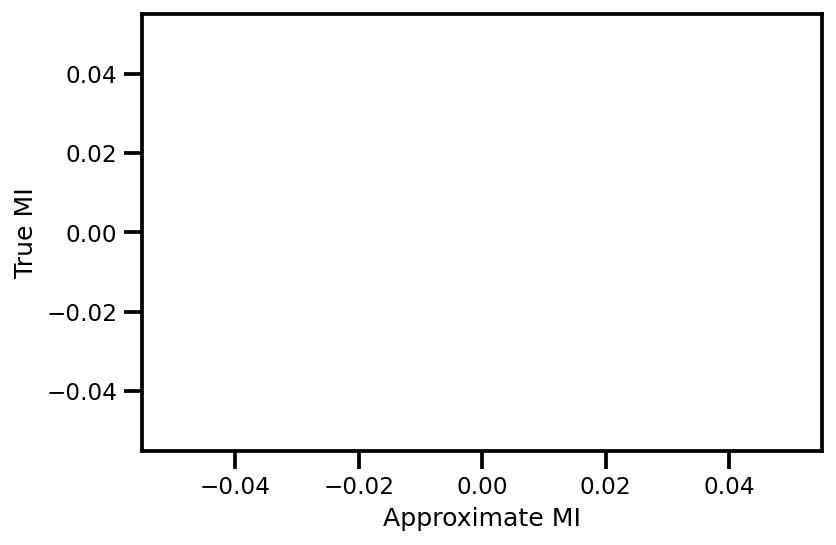

In [69]:
plot_results(results_df, "nhsic_rbf")

#### MMD (RBF)

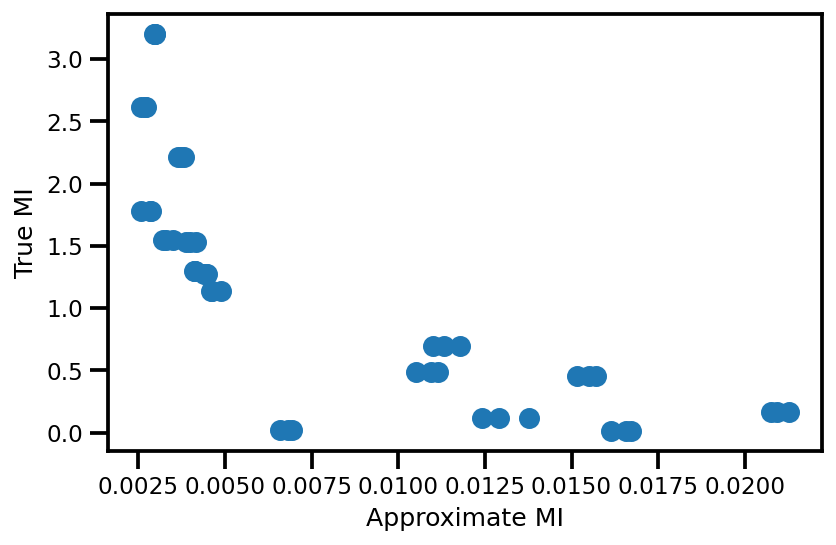

In [71]:
plot_results(results_df, "mmd")

### T-Student Dist.

#### Gaussian Approximation

#### kNN

#### 1 Feature

#### 2 Features

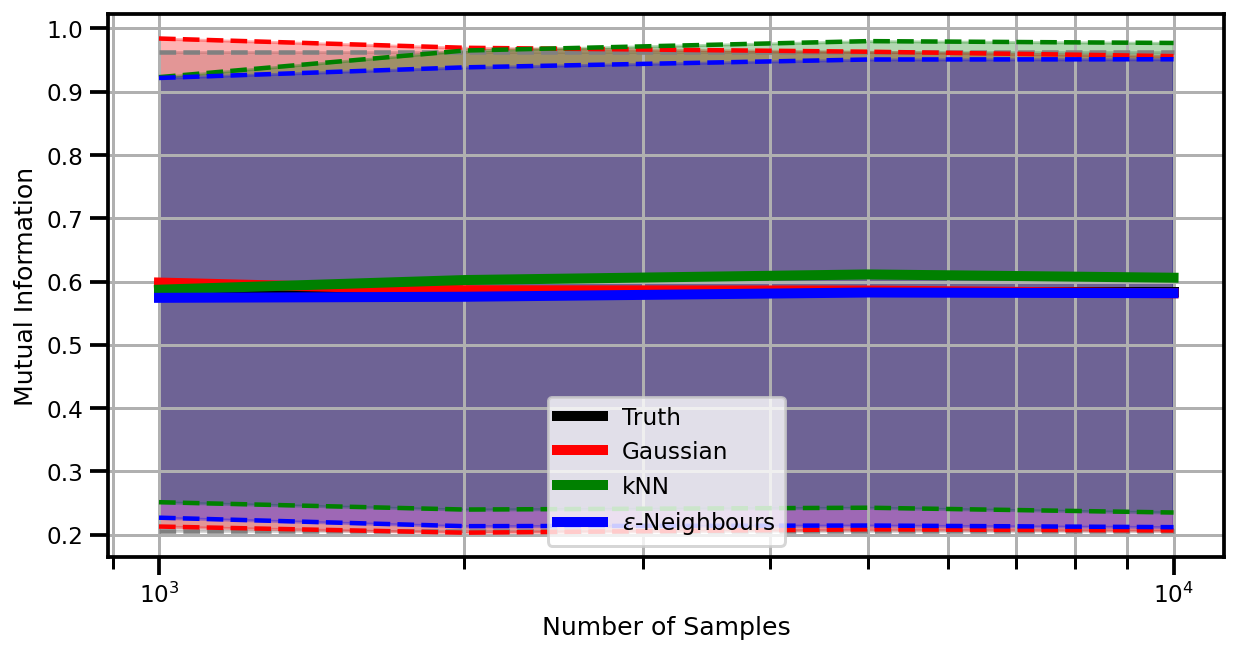

In [17]:
plot_results(results_xr, "gaussian", 2)

#### 5 Features

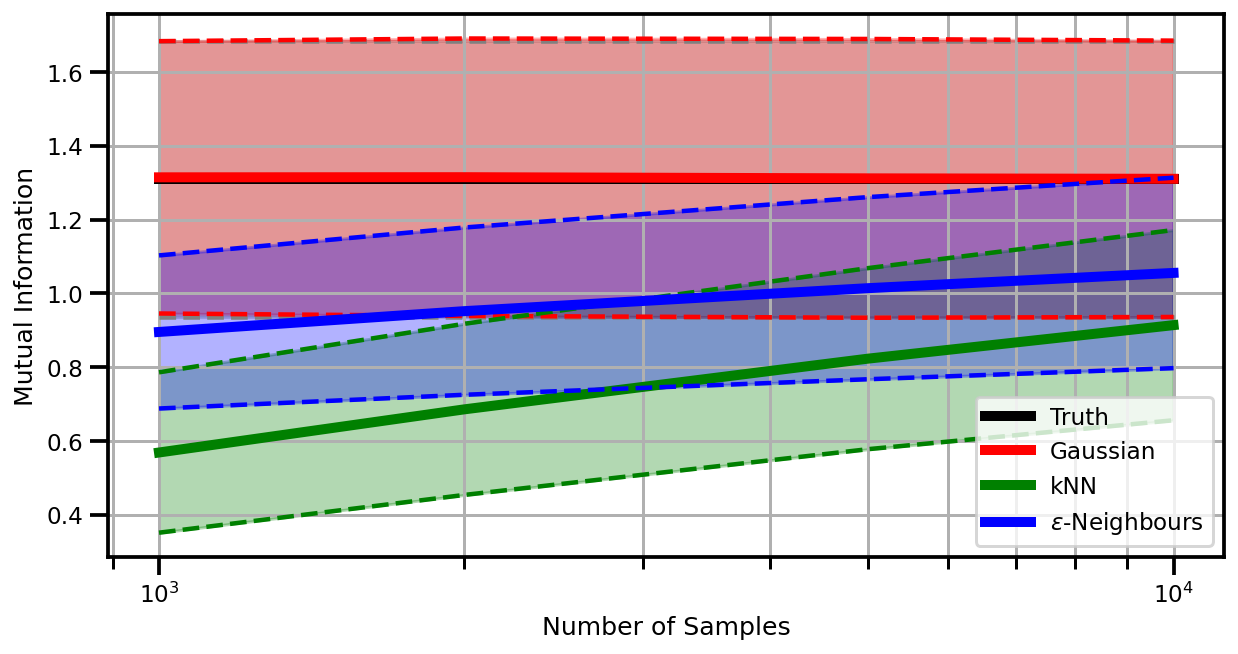

In [18]:
plot_results(results_xr, "gaussian", 5)

#### 10 Features

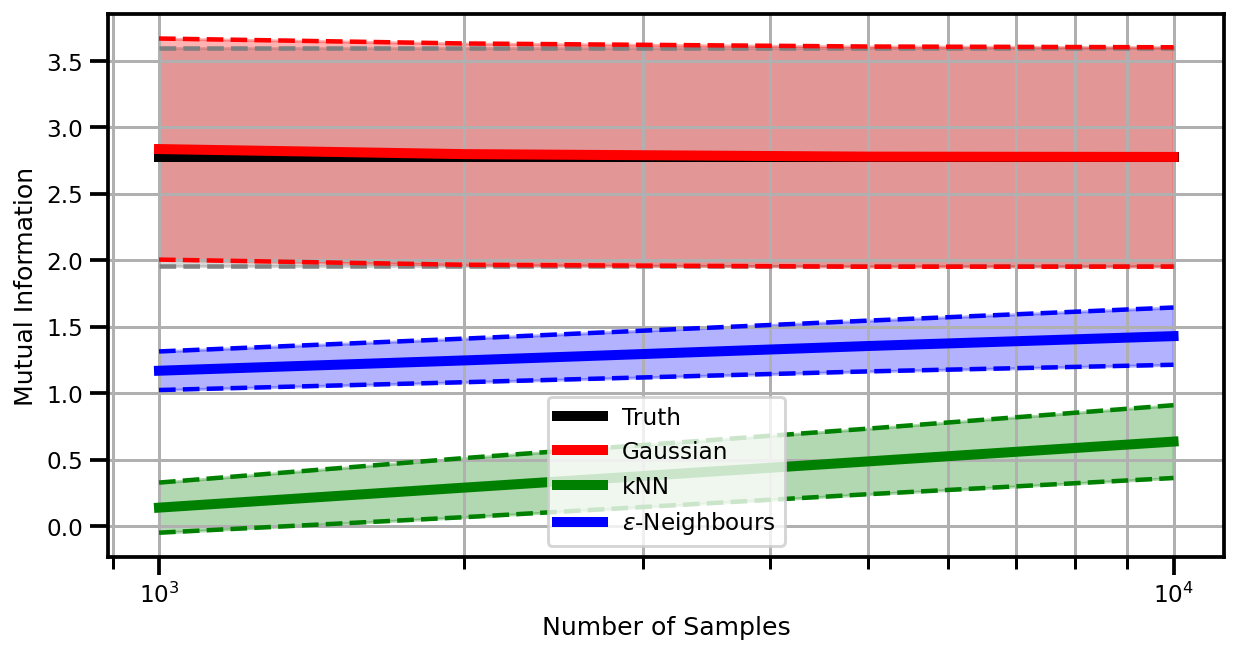

In [19]:
plot_results(results_xr, "gaussian", 10)

### Student T Distribution

#### 1 Features

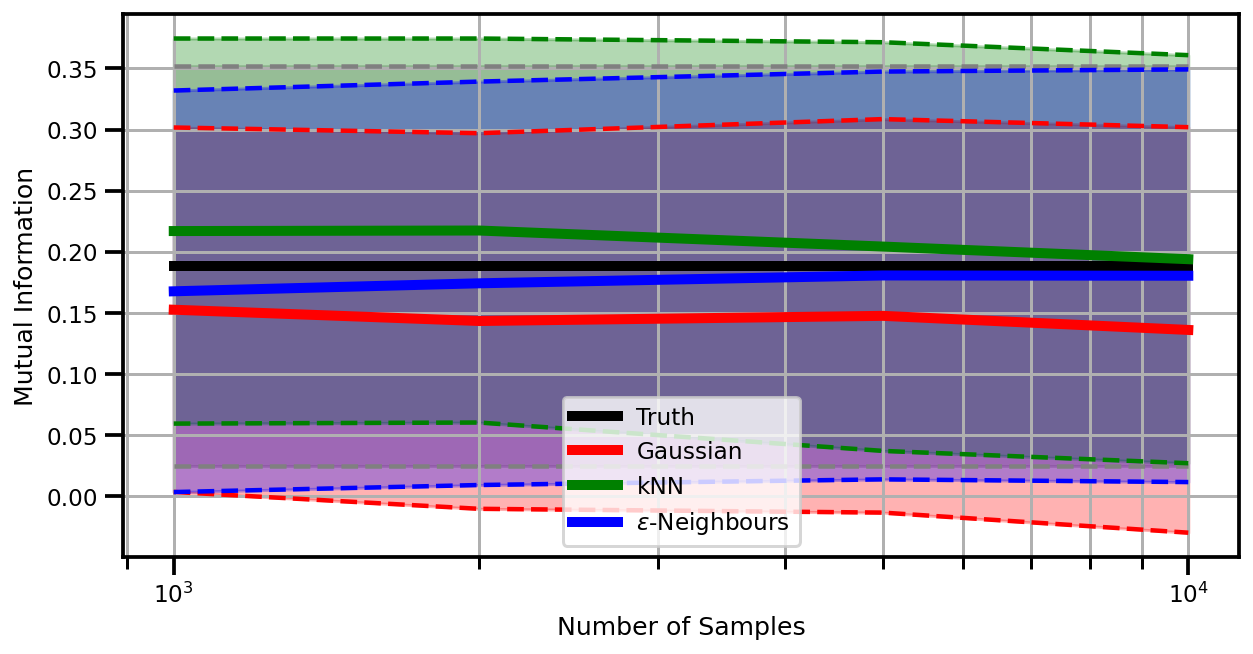

In [20]:
plot_results(results_xr, "studentt", 1)

#### 2 Features

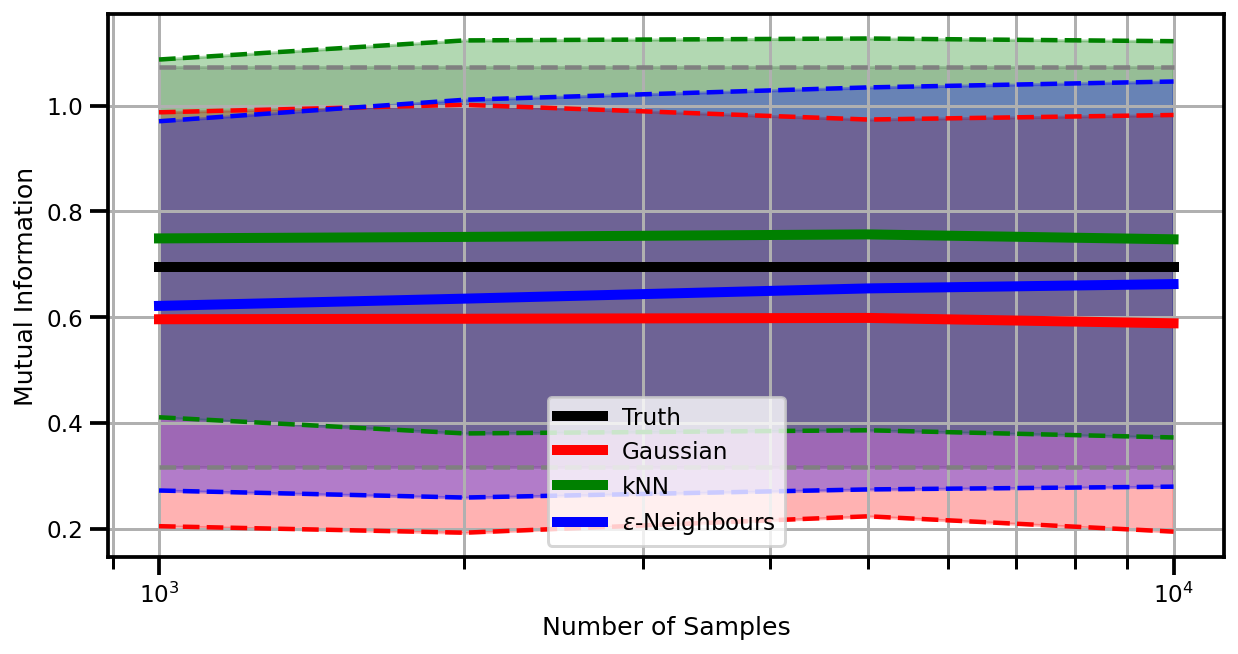

In [21]:
plot_results(results_xr, "studentt", 2)

#### 5 Features

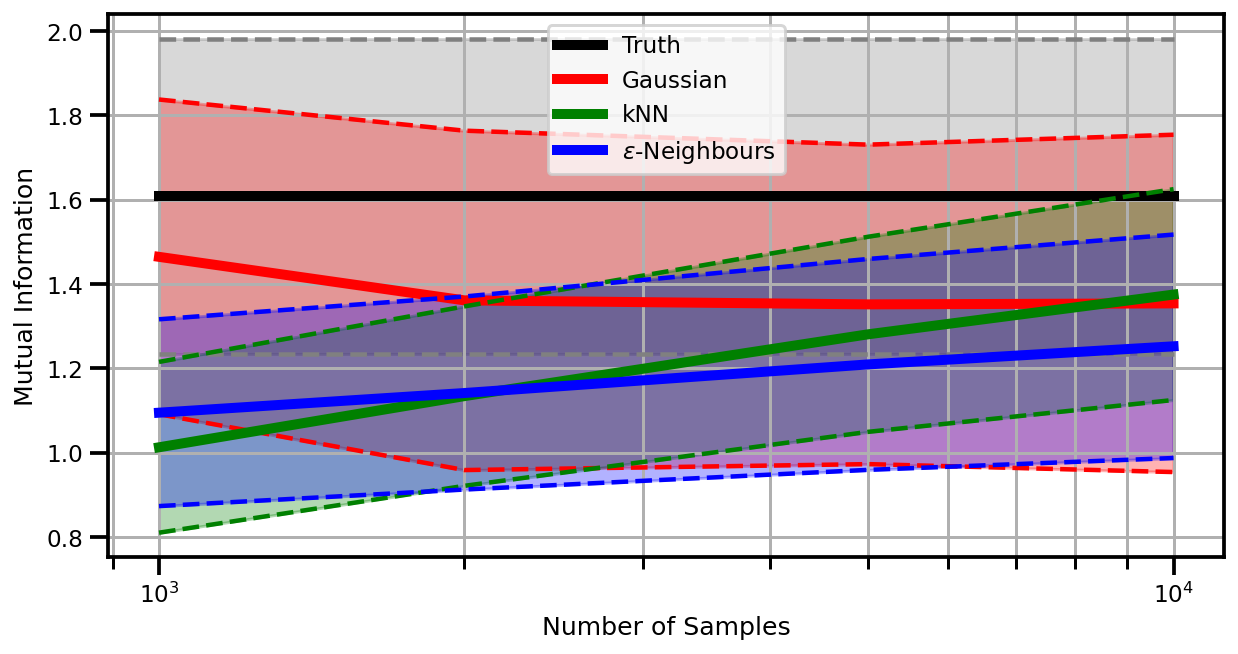

In [22]:
plot_results(results_xr, "studentt", 5)

#### 10 Features

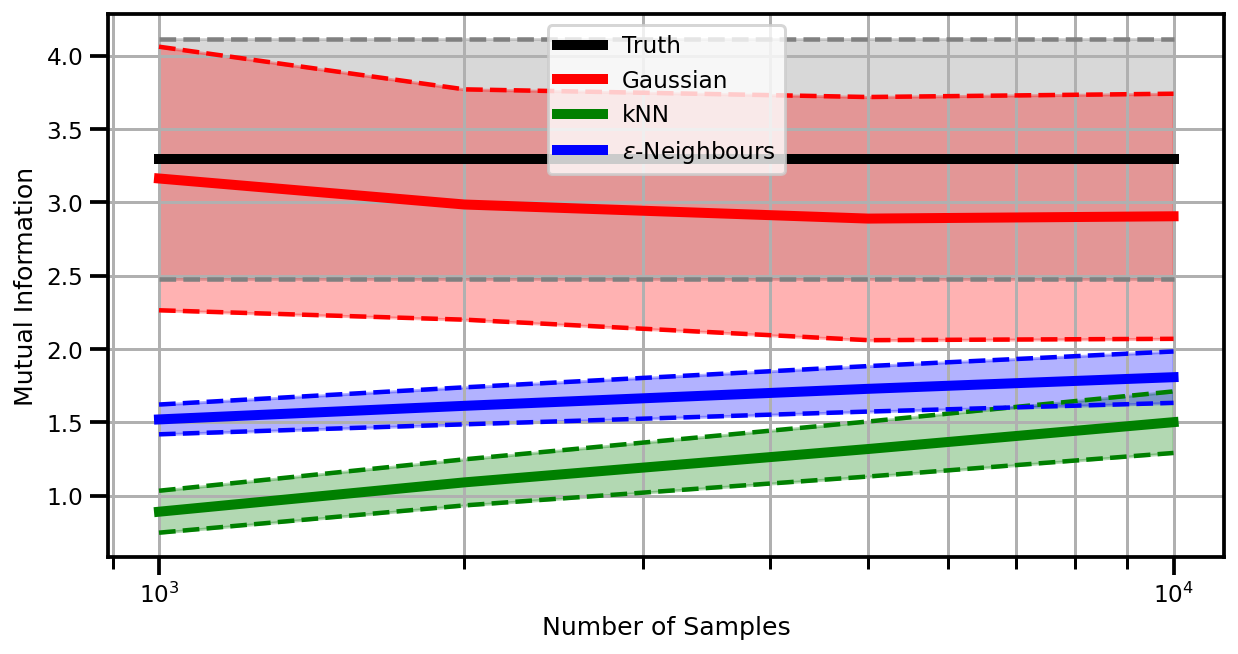

In [23]:
plot_results(results_xr, "studentt", 10)

### Cauchy

#### 1 Features

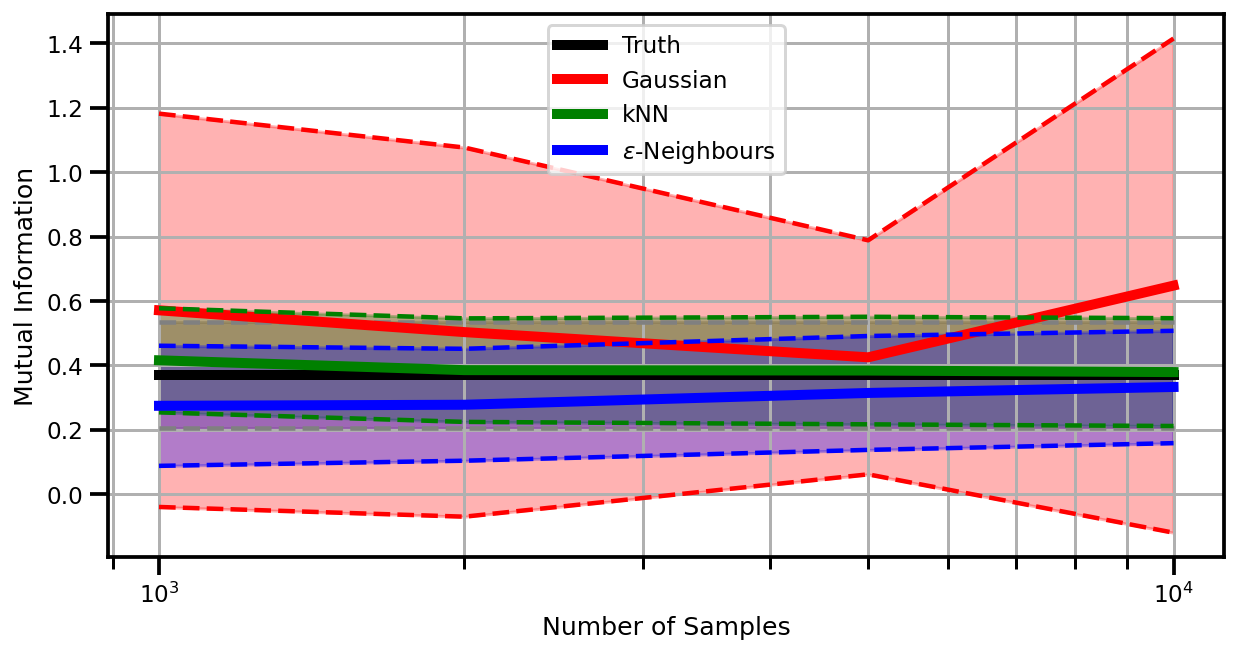

In [24]:
plot_results(results_xr, "cauchy", 1)

#### 2 Features

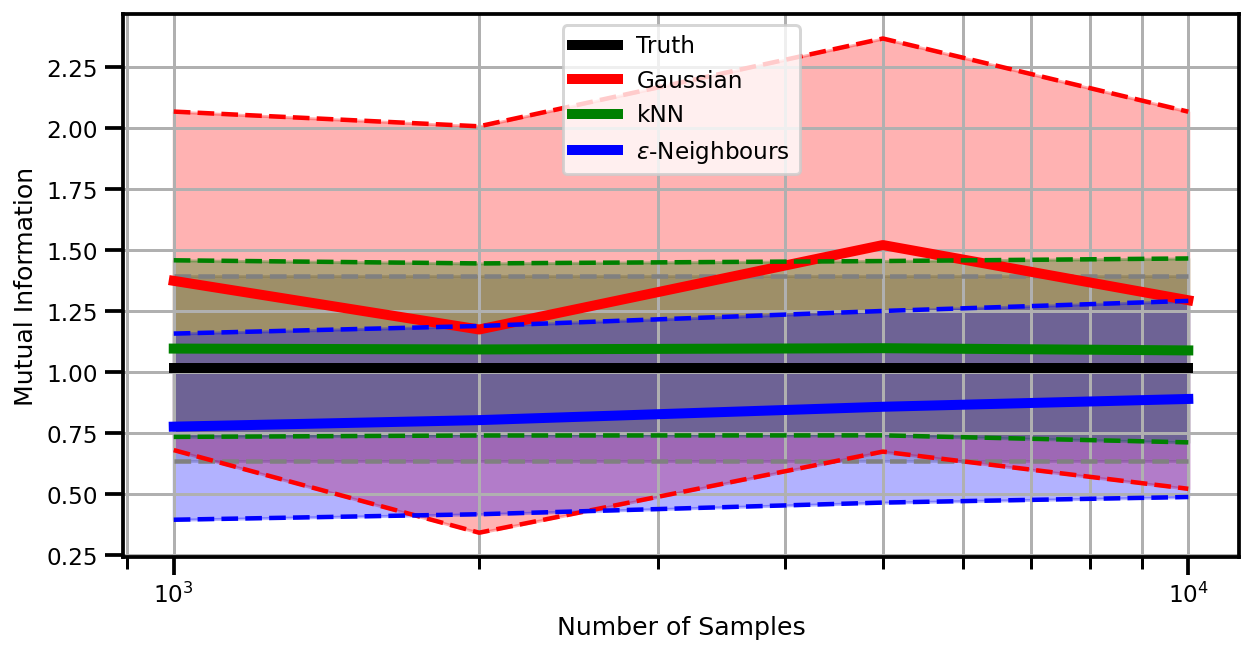

In [25]:
plot_results(results_xr, "cauchy", 2)

#### 5 Features

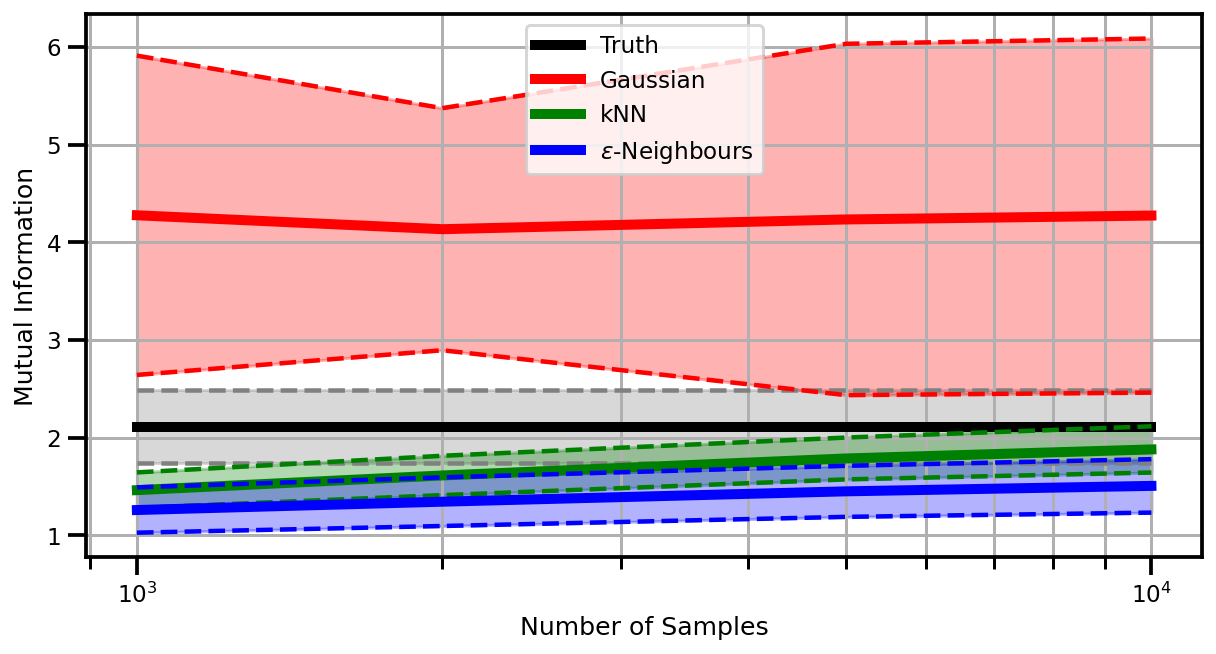

In [26]:
plot_results(results_xr, "cauchy", 5)

#### 10 Features

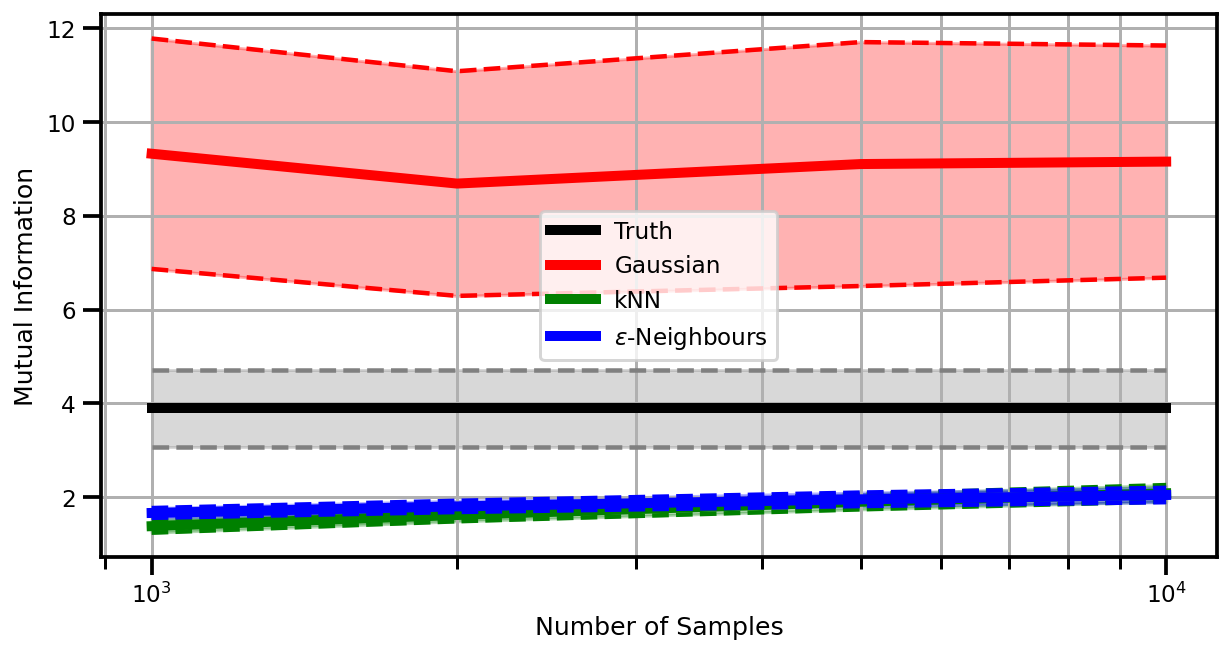

In [27]:
plot_results(results_xr, "cauchy", 10)